In [1]:
import numpy as np
import re 
import math
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import random


##Using Moriarty's own data parsing method 
with open("w07-data.tbl") as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    X = np.array(X)
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)
    
#    N         : number of experiments (columns in the table)
#    G         : number of genes (rows in the table)
#    X[i]      : array of time points, in hrs, for the N experiments
#    S_true[i] : array of sigmas for the experiments
#    Y[i][t]   : GxN: observed tpm for gene i, time point t


# Question 1

The strategy will be as follows: Assume the reisduals are heteroskedastic per the problem and normally distributed. Calculate the log-liklihood by multiplying together the PDFs of the residuals, which are Gaussian. The reisduals $e_i$ follow

$$ e_i = y_i - \hat{y_i} = y_i - (p_0 + p_1 \sin(2 \pi \omega t) + p2 \cos(2 \pi \omega t))$$

where $p_0 = b, p_1 = a \cos(2 \pi \omega \phi), p_2 = a \sin(2\pi \omega \phi)$, which allows us to get a, b, and $\phi$. 


In [2]:
#Prediction of y based on cyclic expression level formula given 
def predict_yhat(X, param):
    p0 = param[0]
    p1 = param[1]
    p2 = param[2]
    yhat = p0 + p1*np.sin(2 * math.pi * X / 24) + p2 * np.cos(2 * math.pi * X / 24)
    return yhat

#Negative log liklihood of the residuals, ditributed Gaussian with varying sigmas 
def nll(param, D, sigmas):
    ll = 0.
    for i, x in enumerate(D):
        residual = x - predict_yhat(X = X[i], param = param)       
        ll      += stats.norm.logpdf(residual, 0, sigmas[i])    
    return -ll

#Init
p0 = (random.randrange(0, 200), random.randrange(-300, 300), random.randrange(-300, 300))

p0_fit = np.zeros(G)
p1_fit = np.zeros(G)
p2_fit = np.zeros(G)

#Minimize, get parameters
for i, row in enumerate(Y):
    result    = optimize.minimize(nll, p0, (row, S_true),bounds = [(0.0,None), (None,None),(None,None)])
    p0_fit[i]    = result.x[0]
    p1_fit[i]    = result.x[1]
    p2_fit[i]    = result.x[2]


In [3]:
b_fit = np.zeros(G)
p_fit = np.zeros(G)
a_fit = np.zeros(G)

#Change parameters to desired 
for g in range(G):
    omega = 1/(24)
    b_fit[g] = p0_fit[g]
    p_fit[g] = np.arctan(p2_fit[g] / p1_fit[g]) / (2 * math.pi * omega)
    a_fit[g] = p1_fit[g] / np.cos(p_fit[g] *2 * math.pi * omega)

    if a_fit[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24


In [4]:
#Display parameter table
colnames = ("b", "a", "phi(hr)")
z = np.vstack((b_fit, a_fit, p_fit))
q = pd.DataFrame(z).T
q.columns = colnames
q.index = genenames
newdf = q.sort_values(by=['phi(hr)'], ascending = False)
newdf


,b,a,phi(hr)
huckleberry,48.020658,25.446551,21.828316
cauliflower,40.855991,25.993014,20.018051
clementine,42.998504,30.307660,18.434851
kiwi,44.162605,28.429263,15.938285
grape,46.542104,23.487021,13.867981
beet,43.517718,21.330635,11.860552
tangerine,42.668034,24.294444,9.696871
lentil,42.853388,22.068069,7.679799
melon,40.100012,25.140894,5.451115
carrot,39.648495,23.138396,3.904266


# Question 2

In [5]:
##Get moriarity table
datafile = "w07-data.tbl"
with open(datafile) as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    X = np.array(X)
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)



# Moriarty's method: ordinary least squares on:
#    y_t = b + (a cos p) sin t + (a sin p) cos t
#
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)

b_fit2 = np.zeros(G)
a_fit2 = np.zeros(G)
p_fit2 = np.zeros(G)

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

for g in range(G):
    # We have to set up a matrix A the way numpy.linalg.lstsq() wants it.
    #
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * math.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * math.pi * X[i] / 24)

    try:
        result    = np.linalg.lstsq(A, Y[g])[0]
    except:
        sys.exit("Linear least square fit failed")
        
    p_fit2[g]  = result[2]  
    b_fit2[g]  = result[0]
    a_fit2[g]  = result[1] 

    p_fit[g]  = np.arctan(result[2] / result[1])   # in radians at first
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])
    
    

    p_fit[g] = 24 * p_fit[g] / (2 * math.pi)       # now in hours
    if a_fit[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24


        
##Original parameter tables for use in (2)
ps =  np.vstack((p0_fit, p1_fit, p2_fit))
ps2 = pd.DataFrame(ps).T
ms = np.vstack((b_fit2, a_fit2, p_fit2))
ms2 = pd.DataFrame(ms).T


colnames = ("b", "a", "phi(hr)")
z = np.vstack((b_fit, a_fit, p_fit))
q2 = pd.DataFrame(z).T
q2.index = genenames
q2.columns = colnames

#Display his parameter table
moriarity_df = q2.sort_values(by=['phi(hr)'], ascending = False)   
moriarity_df

/Users/zacharydiamandis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,b,a,phi(hr)
huckleberry,46.090000,23.419552,23.470680
cauliflower,40.436944,23.670354,21.637109
clementine,40.657222,29.239482,17.321532
kiwi,43.202222,23.967518,16.271247
grape,51.374167,22.535307,13.095663
beet,44.210000,26.079878,11.835912
lentil,44.489167,18.907197,9.136236
tangerine,39.150000,28.419642,7.893135
melon,37.289167,22.886663,3.160582
anise,40.926944,35.166278,3.073257


In [7]:
a=0
#Moriarty
for i in range(len(Y)):
    a += nll(ms2.values[i], Y[i],  S_true)
#mine
b=0
for i in range(len(Y)):
    b += nll(ps2.values[i], Y[i],  S_true)

print(a)
print(b)
diff = a - b 

exp_diff = math.exp(-diff)
print(exp_diff)
exp_diff_avg = math.exp(-diff/12)
print(exp_diff_avg)

455.1479408284538
310.54701041380685
1.587134904595758e-63
5.844102443423925e-06


Moriarty wrongly assumed residuals are normally distributed with the same standard deviation in his harmonic regression, while in reality they exhibit heteroskedasticity. This results in a summed negative log liklihood of 455 for him and 310 for me, where lower is better. My model is more likely by the 1.58e-63 measure, however this is not a meaningful comparison. A better way to compare is to compute the average liklihood, which is the total divided by the number of lines (genes). So the average liklihood is about 5.844e-06 times better. 

# Question 3

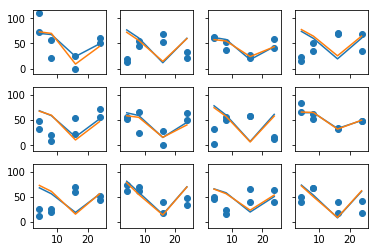

In [8]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey = True)
#Scatterplot
for i in range(3):
    for j in range(4):
            ax[i][j].scatter(X, Y[4*i +j])

#Plot the fits. Note: I tried to do this more code-efficiently with a loop, but couldn't get good results
ax[0][0].plot(X, q.values[0][0] + q.values[0][1]*np.sin(2 * math.pi * X / 24) + q.values[0][2]* np.cos(2 * math.pi * X / 24))
ax[0][0].plot(X, q2.values[0][0] + q2.values[0][1]*np.sin(2 * math.pi * X / 24) + q2.values[0][2]* np.cos(2 * math.pi * X / 24))

ax[0][1].plot(X, q.values[1][0] + q.values[1][1]*np.sin(2 * math.pi * X / 24) + q.values[1][2]* np.cos(2 * math.pi * X / 24))
ax[0][1].plot(X, q2.values[1][0] + q2.values[1][1]*np.sin(2 * math.pi * X / 24) + q2.values[1][2]* np.cos(2 * math.pi * X / 24))


ax[0][2].plot(X, q.values[2][0] + q.values[2][1]*np.sin(2 * math.pi * X / 24) + q.values[2][2]* np.cos(2 * math.pi * X / 24))
ax[0][2].plot(X, q2.values[2][0] + q2.values[2][1]*np.sin(2 * math.pi * X / 24) + q2.values[2][2]* np.cos(2 * math.pi * X / 24))

ax[0][3].plot(X, q.values[3][0] + q.values[3][1]*np.sin(2 * math.pi * X / 24) + q.values[3][2]* np.cos(2 * math.pi * X / 24))
ax[0][3].plot(X, q2.values[3][0] + q2.values[3][1]*np.sin(2 * math.pi * X / 24) + q2.values[3][2]* np.cos(2 * math.pi * X / 24))


ax[1][0].plot(X, q.values[4][0] + q.values[4][1]*np.sin(2 * math.pi * X / 24) + q.values[4][2]* np.cos(2 * math.pi * X / 24))
ax[1][0].plot(X, q2.values[4][0] + q2.values[4][1]*np.sin(2 * math.pi * X / 24) + q2.values[4][2]* np.cos(2 * math.pi * X / 24))


ax[1][1].plot(X, q.values[5][0] + q.values[5][1]*np.sin(2 * math.pi * X / 24) + q.values[5][2]* np.cos(2 * math.pi * X / 24))
ax[1][1].plot(X, q2.values[5][0] + q2.values[5][1]*np.sin(2 * math.pi * X / 24) + q2.values[5][2]* np.cos(2 * math.pi * X / 24))


ax[1][2].plot(X, q.values[6][0] + q.values[6][1]*np.sin(2 * math.pi * X / 24) + q.values[6][2]* np.cos(2 * math.pi * X / 24))
ax[1][2].plot(X, q2.values[6][0] + q2.values[6][1]*np.sin(2 * math.pi * X / 24) + q2.values[6][2]* np.cos(2 * math.pi * X / 24))


ax[1][3].plot(X, q.values[7][0] + q.values[7][1]*np.sin(2 * math.pi * X / 24) + q.values[7][2]* np.cos(2 * math.pi * X / 24))
ax[1][3].plot(X, q2.values[7][0] + q2.values[7][1]*np.sin(2 * math.pi * X / 24) + q2.values[7][2]* np.cos(2 * math.pi * X / 24))


ax[2][0].plot(X, q.values[8][0] + q.values[8][1]*np.sin(2 * math.pi * X / 24) + q.values[8][2]* np.cos(2 * math.pi * X / 24))
ax[2][0].plot(X, q2.values[8][0] + q2.values[8][1]*np.sin(2 * math.pi * X / 24) + q2.values[8][2]* np.cos(2 * math.pi * X / 24))

ax[2][1].plot(X, q.values[9][0] + q.values[9][1]*np.sin(2 * math.pi * X / 24) + q.values[9][2]* np.cos(2 * math.pi * X / 24))
ax[2][1].plot(X, q2.values[9][0] + q2.values[9][1]*np.sin(2 * math.pi * X / 24) + q2.values[9][2]* np.cos(2 * math.pi * X / 24))

ax[2][2].plot(X, q.values[10][0] + q.values[10][1]*np.sin(2 * math.pi * X / 24) + q.values[10][2]* np.cos(2 * math.pi * X / 24))
ax[2][2].plot(X, q2.values[10][0] + q2.values[10][1]*np.sin(2 * math.pi * X / 24) + q2.values[10][2]* np.cos(2 * math.pi * X / 24))

ax[2][3].plot(X, q.values[11][0] + q.values[11][1]*np.sin(2 * math.pi * X / 24) + q.values[11][2]* np.cos(2 * math.pi * X / 24))
ax[2][3].plot(X, q2.values[11][0] + q2.values[11][1]*np.sin(2 * math.pi * X / 24) + q2.values[11][2]* np.cos(2 * math.pi * X / 24))


My model appears to do a very slightly better job of fitting, which is likely why my liklihood was only very slightly better. 

In [9]:

y = q[["phi(hr)"]]
y.index = genenames


h = q2[["phi(hr)"]]
h.index = genenames

#Comparison table of phis 
colnames = (("my_phi", "moriarty_phi"))
mf = pd.concat([y,h], axis=1)
mf.columns = colnames
mf






,my_phi,moriarty_phi
anise,2.222912,3.073257
kiwi,15.938285,16.271247
carrot,3.904266,2.708109
grape,13.867981,13.095663
tangerine,9.696871,7.893135
melon,5.451115,3.160582
clementine,18.434851,17.321532
spinach,0.018888,0.866472
beet,11.860552,11.835912
huckleberry,21.828316,23.470680


In [10]:
#My table with ascending values of phi. This is my predicted cyclic order of the twelve genes 
mypd = mf[["my_phi"]].sort_values(by=["my_phi"], ascending = True)   
mypd

,my_phi
spinach,0.018888
anise,2.222912
carrot,3.904266
melon,5.451115
lentil,7.679799
tangerine,9.696871
beet,11.860552
grape,13.867981
kiwi,15.938285
clementine,18.434851


In [11]:
#Moriarty's table with ascending values of phi. This is his predicted cyclic order of the twelve genes 
mpd = mf[["moriarty_phi"]].sort_values(by=["moriarty_phi"], ascending = True)   
mpd

,moriarty_phi
spinach,0.866472
carrot,2.708109
anise,3.073257
melon,3.160582
tangerine,7.893135
lentil,9.136236
beet,11.835912
grape,13.095663
kiwi,16.271247
clementine,17.321532


Text(0.5,0.98,"('anise', 'carrot', 'melon', 'lentil', 'tangerine')")

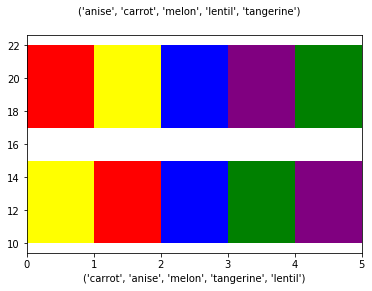

In [12]:
#Visualization of the difference in order for the relevant different genes between me and moriarity
#Mine is on top, Moriarty on bottom 
fig, ax = plt.subplots()
ax.broken_barh([(0, 1), (1, 2), (2,3) , (3,4), (4,5)], (10, 5), facecolors=('yellow', 'red', 'blue', 'green' ,'purple'))
ax.broken_barh([(0, 1), (1, 2), (2, 3), (3,4), (4,5)], (17, 5),
               facecolors=('red', 'yellow', 'blue', 'purple' ,'green'))

ax.set_xlim(0, 5)
plt.xlabel(('carrot', 'anise', 'melon', 'tangerine' ,'lentil'))
fig.suptitle(('anise', 'carrot' , 'melon', 'lentil', 'tangerine'), fontsize=10)

Our orders differ for genes anise/carrot (red/yellow) and lentil/tangerine (purple/green). Above, you can see the order for 5 relevant genes where our model's disagree. My order is on the top (Anise-Carrot-Melon-Lentil-Tangerine) and Moriarty's on the bottom (Carrot-Anise-Melon-Tangerine-Lentil). While my liklihood is only marginally better, it did produce this significant re-ordering of four genes. This result is highly significant in application. For example, in a drug trial concerning these genes it would be extremely critical to correctly know the order of the gene's expression to best tailor the drug for treatment.  